In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw5.ipynb")

## Homework #5

*Please edit the cell below to add your full name (first and last) and the full names of any group members that you collaborated with on this assignment.* 

Name: Runze Li    
Group Members: None   
***

In [2]:
# Set random seed and ensure plots are displayed in the notebook
import numpy as np
import arviz as az
rnd_seed = 42
np.random.seed(rnd_seed)
%matplotlib inline

%config Inline.figure_format = 'retina'
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<!-- BEGIN QUESTION -->

**Question 1**. **(20 points)** The data in *Data/NWOGrants.csv* are outcomes for scientific funding applications for the Netherlands Organization for Scientific Research (NWO) from 2010–2012 (see [van der Lee and Ellemers](https://doi.org/10.1073/pnas.1510159112)).

 These data have a very similar structure to the UC Berkeley Admissions data discussed in lecture. 

* Include an image of a directed acyclic graph (DAG) for this data that represents the relationship between the variables.  **(Do not include the number of applications in your DAG or statistical model)**. 

    **Note** : *Refer to **dag_tutorial.ipynb** for instructions on how to include an DAG in your Jupyter notebook using Python.*

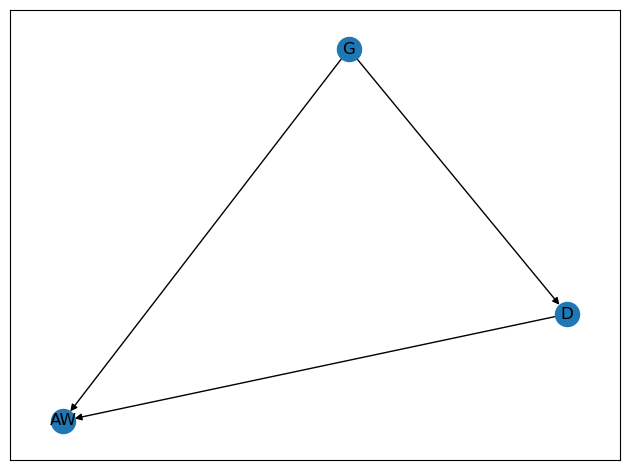

In [3]:
# Write code here
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.DiGraph()
graph.add_edges_from([("G", "D"), ("D", "AW"), ("G", "AW")])
nx.draw_networkx(graph, arrows=True)
plt.tight_layout()

Use a Binomial GLM to estimate the TOTAL causal effect of reported gender on grant awards. 

Notes:  
- You **must provide justification** for the prior distributions used in your model to receive full credit.
- You can communicate your estimate using a summary table or a plot (a plot is preferred).
- You can also use logistic regression for your solution but this will require disaggregating the data.

__Answer:__   
If the variance is too large, the logistic values will all become 0 or 1. So here we set the prior distribution, alpha = Normal(0, 1), which can get a relatively ideal results.

In [4]:
# Write code here
import pandas as pd
import pymc as pm

df = pd.read_csv("Data/NWOGrants.csv", header=0)

D = pd.Categorical(df.discipline).codes
G = np.where(df["gender"]=='f', 0, 1)
AP = df.applications
AW = df.awards

# total effect gender on awards
with pm.Model() as m_G:
    alpha = pm.Normal("alpha", 0, 1, shape=2)
    p = pm.Deterministic("p", pm.math.invlogit(alpha[G]))
    mod_AW = pm.Binomial("AW", AP, p, observed=AW)
    idata_G = pm.sample()

az.summary(idata_G, var_names="~p", kind="all")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-1.734,0.082,-1.858,-1.596,0.002,0.001,1920.0,1386.0,1.0
alpha[1],-1.528,0.066,-1.629,-1.417,0.001,0.001,2246.0,1411.0,1.0


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Provide a gender contrast plot and a written interpretation of the plot.

__Answer:__   
According to the plot, we find that men have a higher probability of winning the prize than women, because diff_prob is a negative number, indicating that women have a lower chance of winning than men.

/tmp/ipykernel_500/25670801.py:5: FutureWarning: extract_dataset has been deprecated, please use extract
  post = az.extract_dataset(idata_G) #extract all posterior samples
/opt/conda/envs/fnds/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


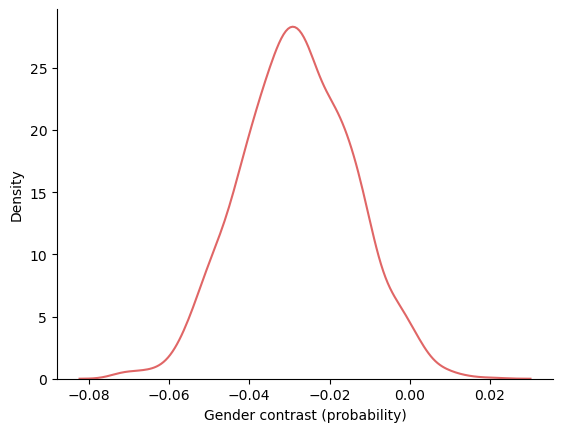

In [5]:
# Write code here
import seaborn as sns
from scipy.special import expit as logistic

post = az.extract_dataset(idata_G) #extract all posterior samples 
probA_G0 = logistic(post.alpha[0])
probA_G1 = logistic(post.alpha[1])
diff_prob = probA_G0 - probA_G1

sns.kdeplot(diff_prob, color="#e06666")
plt.xlabel("Gender contrast (probability)")
sns.despine()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2**. **(22 points)** Now estimate the AVERAGE DIRECT causal effect of gender on grant awards using a counterfactual simulation as demonstrated in lecture.

**Note** : _Refer to the counterfactual simulation for UC Berkeley admission outcomes from the lecture on Bernoulli/Binomial Generalized Linear Models for guidance. Its ok to just write code and generate plots for this question. Question 3 focuses on interpreting the results from this question._

_Type your answer here, replacing this text._

In [6]:
# Write code here
with pm.Model() as m_GD_cf:
    d_G = pm.MutableData("gender", G.astype("int64"))
    d_D = pm.MutableData("discipline", D.astype("int64"))
    d_AP = pm.MutableData("applications", AP.astype("int64"))
    
    alpha = pm.Normal("alpha", 0, 1, shape=(2, len(np.unique(D))))
    p = pm.Deterministic("p", pm.math.invlogit(alpha[d_G, d_D]))
    mod_AW = pm.Binomial("A", d_AP, p, observed=AW, shape=d_D.shape[0])
    
    idata_GD_cf = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [7]:
total_apps = df.applications.sum()
apps_per_disc = df.groupby("discipline")["applications"].sum()

with m_GD_cf:
    # simulate as if all apps from women
    pm.set_data(
            {
                "discipline": np.repeat(range(len(apps_per_disc)), apps_per_disc),
                "applications": np.repeat(1, total_apps),
                "gender": np.repeat(0, total_apps)
            }
    )

    cf_A_G0 = pm.sample_posterior_predictive(idata_GD_cf)

with m_GD_cf:
    # simulate as if all apps from men
    pm.set_data(
            {
                "discipline": np.repeat(range(len(apps_per_disc)), apps_per_disc),
                "applications": np.repeat(1, total_apps),
                "gender": np.repeat(1, total_apps)
            }
    )

    cf_A_G1 = pm.sample_posterior_predictive(idata_GD_cf)

Sampling: [A]


Sampling: [A]


After estimating the average direct causal effect of gender on grant awards:
1. Plot the average direct causal effect as a contrast plot from the results of the counterfactual simulation.

/opt/conda/envs/fnds/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


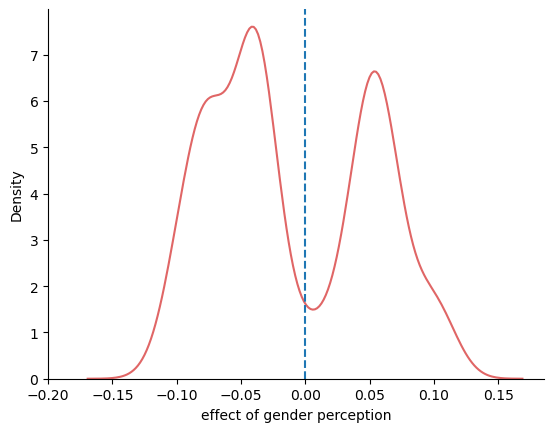

In [8]:
# Write code here

admitted_G0 = az.extract(cf_A_G0, group="posterior_predictive")
admitted_G1 = az.extract(cf_A_G1, group="posterior_predictive")

num_samples = admitted_G0.A.values.shape[1]
admit_rate_G0 = admitted_G0.A.values.sum(1) / num_samples
admit_rate_G1 = admitted_G1.A.values.sum(1) / num_samples

# plot contrast
sns.kdeplot(admit_rate_G0 - admit_rate_G1, color="#e06666")
plt.xlabel("effect of gender perception")
plt.xlim(left=-0.2)
plt.axvline(0, linestyle="--")
sns.despine();

2. Plot the DIRECT causal effect of reported gender by discipline, weighting each discipline in proportion to the number of applications in the observed data. 

* **Add a legend** to your plot to label the discipline distributions. You can find documentation for adding a legend to your plot [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html). Specify a `label` each time you plot a distribution and call the `matplotlib.pyplot.label()` function before displaying the full plot.

In [9]:
# Write code here

with pm.Model() as m_GD:
    alpha = pm.Normal("alpha", 0, 1, shape=(2, len(np.unique(D))))
    p = pm.Deterministic("p", pm.math.invlogit(alpha[G, D]))
    mod_AW = pm.Binomial("AW", AP, p, observed=AW)
    
    idata_GD = pm.sample()

az.summary(idata_GD, var_names="~p", kind="all")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[0, 0]",-0.965,0.337,-1.462,-0.383,0.005,0.004,3757.0,1714.0,1.0
"alpha[0, 1]",-1.707,0.236,-2.107,-1.355,0.003,0.003,4774.0,1315.0,1.0
"alpha[0, 2]",-1.391,0.188,-1.687,-1.080,0.003,0.002,5035.0,1574.0,1.0
"alpha[0, 3]",-1.205,0.260,-1.614,-0.803,0.004,0.003,4516.0,1459.0,1.0
"alpha[0, 4]",-2.018,0.190,-2.315,-1.703,0.003,0.002,3809.0,1557.0,1.0
"alpha[0, 5]",-1.080,0.354,-1.584,-0.458,0.006,0.005,3567.0,1498.0,1.0
"alpha[0, 6]",-0.839,0.604,-1.754,0.199,0.009,0.009,4670.0,1606.0,1.0
"alpha[0, 7]",-2.001,0.150,-2.237,-1.771,0.002,0.002,4181.0,1174.0,1.0
"alpha[0, 8]",-1.243,0.292,-1.684,-0.782,0.004,0.004,4395.0,1594.0,1.0
"alpha[1, 0]",-0.972,0.239,-1.338,-0.585,0.004,0.003,3669.0,1652.0,1.0


/tmp/ipykernel_500/1151706123.py:4: FutureWarning: extract_dataset has been deprecated, please use extract
  post2 = az.extract_dataset(idata_GD)
/tmp/ipykernel_500/1151706123.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  _ = sns.kdeplot(diff_prob_D, linewidth=1+5*w[i])
/opt/conda/envs/fnds/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_500/1151706123.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc

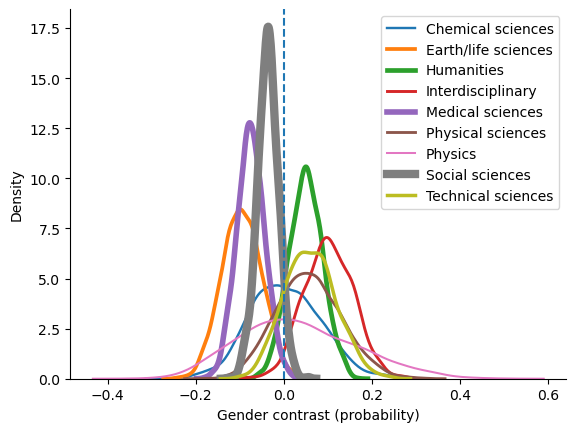

In [10]:
w = apps_per_disc / total_apps
w = w/max(w)

post2 = az.extract_dataset(idata_GD) 

n_deps = post2.alpha.shape[1]

probA = logistic(post2.alpha)

for i in range(n_deps):
    probA_G0_D = probA[0][i]
    probA_G1_D = probA[1][i]
    diff_prob_D = probA_G0_D - probA_G1_D
    _ = sns.kdeplot(diff_prob_D, linewidth=1+5*w[i])

plt.legend(w.index.tolist())
plt.axvline(x=0, linestyle="--")
plt.xlabel("Gender contrast (probability)")
sns.despine();

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 3**. **(8 points)** Considering the total effect (Question 1) and the direct effects (Question 2) of listed gender, what causes seem to contribute to the differences between women and men in award rate in this dataset?

It is not necessary to say whether or not there is evidence of discrimination. Simply explain how the direct effects you have estimated make sense (or not) of the total effect.

__Answer:__   
The total effect (Question 1) suggests that there are some differences in award rates between gender, while the direct effect (Question 2) suggests that different disciplines also have an impact on award rates.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

What explanations might be unaccounted for regarding differences in award outcomes observed in this dataset? 

Provide at least one potential unobserved confound that might impact the statistical inference performed in this problem.

__Answer:__   
Personal Quality is a potential unobserved confound. Specifically, if different scholars in the same field have different personal qualities, this could also have some effect on the results.

In [11]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)